<a href="https://colab.research.google.com/github/csaundersshultz/HotLINK/blob/main/HotLINK_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HotLINK Tutorial**
This notebook is intended to serve as a tutorial for the Hotspot Learning and Identification Network (HotLINK). For this tutorial we use VIIRS (SNPP) data at Shishaldin Volcano for the month of July 2019, with eruption onset 2019-07-12. Code cells below perform the following actions, in order:

1. Install hotlink via github
2. Load and visualize one image from the example dataset
3. Import functions to normalize and crop the example image
4. Load the model and make a prediction for a single image
5. Calculate radiative power and brightness temperatue for that image, and visualize the detected pixels
6. Then load all the example images, apply the model to all of the images, and then visualize as a time series of detections.

## Downloading data:
Note, this tutorial does not go through the data download process, but starts with already cropped level 1b VIIRS data. To download your own data of interest, whether VIIRS or MODIS, you can follow the steps on the NASA Earthdata website [Link], and process the files using the crop_to_tiff function of the hotlink package.

# 1. Install hotlink



In [12]:
#install the hotlink package from github
!pip install --quiet git+https://github.com/csaundersshultz/HotLINK.git@v1.0

  Preparing metadata (setup.py) ... done


# 2. Load example image

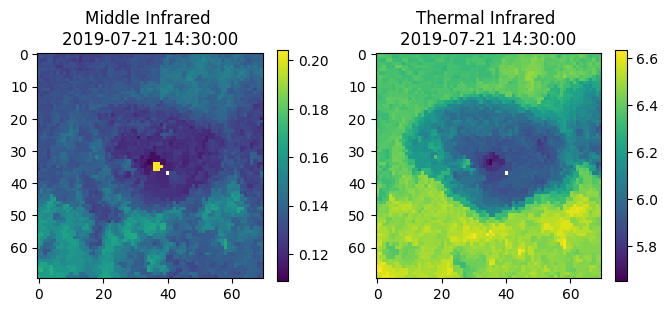

In [14]:
#visualize an image from the example dataset
from hotlink import load_example_data
import matplotlib.pyplot as plt
import numpy as np

mir, tir, d8 = load_example_data(170) #load image 160/256

fig,axs = plt.subplots(figsize=(8,4), ncols=2)
im0 = axs[0].imshow(mir)
plt.colorbar(im0, ax=axs[0], shrink=0.75)
t = axs[0].set_title(f"Middle Infrared \n{d8}")
im1 = axs[1].imshow(tir)
plt.colorbar(im1, ax=axs[1], shrink=0.75)
t = axs[1].set_title(f"Thermal Infrared \n{d8}")

As you can see, the data is not normalized. It is also 70x70, and the model requires images of size of 64x64. Next we will load some support functions to normalize and crop the data.
# 3. Pre-processing

In [15]:
from hotlink.support_functions import crop_center, normalize_MIR, normalize_TIR

n_mir = normalize_MIR(mir) #note, normalize also fills in missing pixels
n_tir = normalize_TIR(tir)
stacked = np.dstack([n_mir, n_tir])
print(f"The stacked image shape is {stacked.shape}")
cropped = crop_center(stacked)
print(f"After cropping the image shape is {cropped.shape}")

The stacked image shape is (70, 70, 2)
After cropping the image shape is (64, 64, 2)


# 4. Predicting a single image
Now that we have prepared this image, we can load the hotlink model and then use it to detect hotspot pixels within the image. Notice that the input to the model is a numpy array with shape [1, 64, 64,2], this corresponds to 1 image, height and width of 64, and 2 bands (MIR first and then TIR). The model can also be used to predict multiple images at once, which we will use later.

The output size is [1, 24, 24, 3]. The prediction is made for a central region in the input image, and contains probabilities for three classes in the final dimension --> (0=background, 1=hotspot adjacent, 2=hotspot).


1/1 [==============================] - 0s 141ms/step


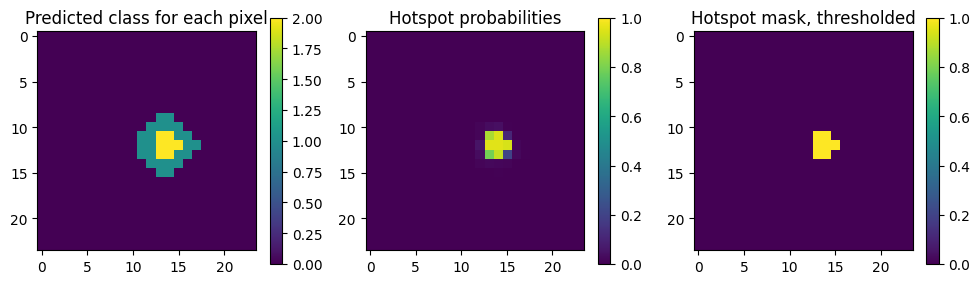

In [16]:
from hotlink import load_hotlink_model
from skimage.filters import apply_hysteresis_threshold

model = load_hotlink_model() #load the model

input = cropped.reshape(1,64,64,2)

# make probabilistic prediction
prediction = model.predict(input) #shape=[batch_size, 24, 24, 3], for 3 predicted classes:background, hotspot-adjacent, and hotspot

# get predicted class for each pixel (highest probability)
pred_classes = np.array(np.argmax(prediction[0,:,:,:], axis=2)) #classes 0,1,2 correspond to bg, hot-adjacent, and hot

# use hysteresis thresholding to generate a binary map of hotspot pixels
prob_active = prediction[0,:,:,2] #map with probabilities of active class
max_prob = np.max(prob_active) #highest probability per image, equated to probability that the image contains a hotspot
hotspot_mask = apply_hysteresis_threshold(prob_active, low=0.4, high=0.5).astype('int') #hysteresis thresholding active mask

#now visualize some of the layers:
fig, axs = plt.subplots(ncols=3, figsize=(12,4))
im0 = axs[0].imshow(pred_classes)
plt.colorbar(im0, ax=axs[0], shrink=0.8)
axs[0].set_title("Predicted class for each pixel")

im1 = axs[1].imshow(prob_active, vmin=0, vmax=1)
plt.colorbar(im1, ax=axs[1], shrink=0.8)
axs[1].set_title("Hotspot probabilities")

im2 = axs[2].imshow(hotspot_mask)
plt.colorbar(im2, ax=axs[2], shrink=0.8)
txt = axs[2].set_title("Hotspot mask, thresholded")


# 5. Calculating metrics and displaying hotspot detection
We load three functions from hotlink: radiative_power(), brightness_temperature(), and plot_detection()

/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


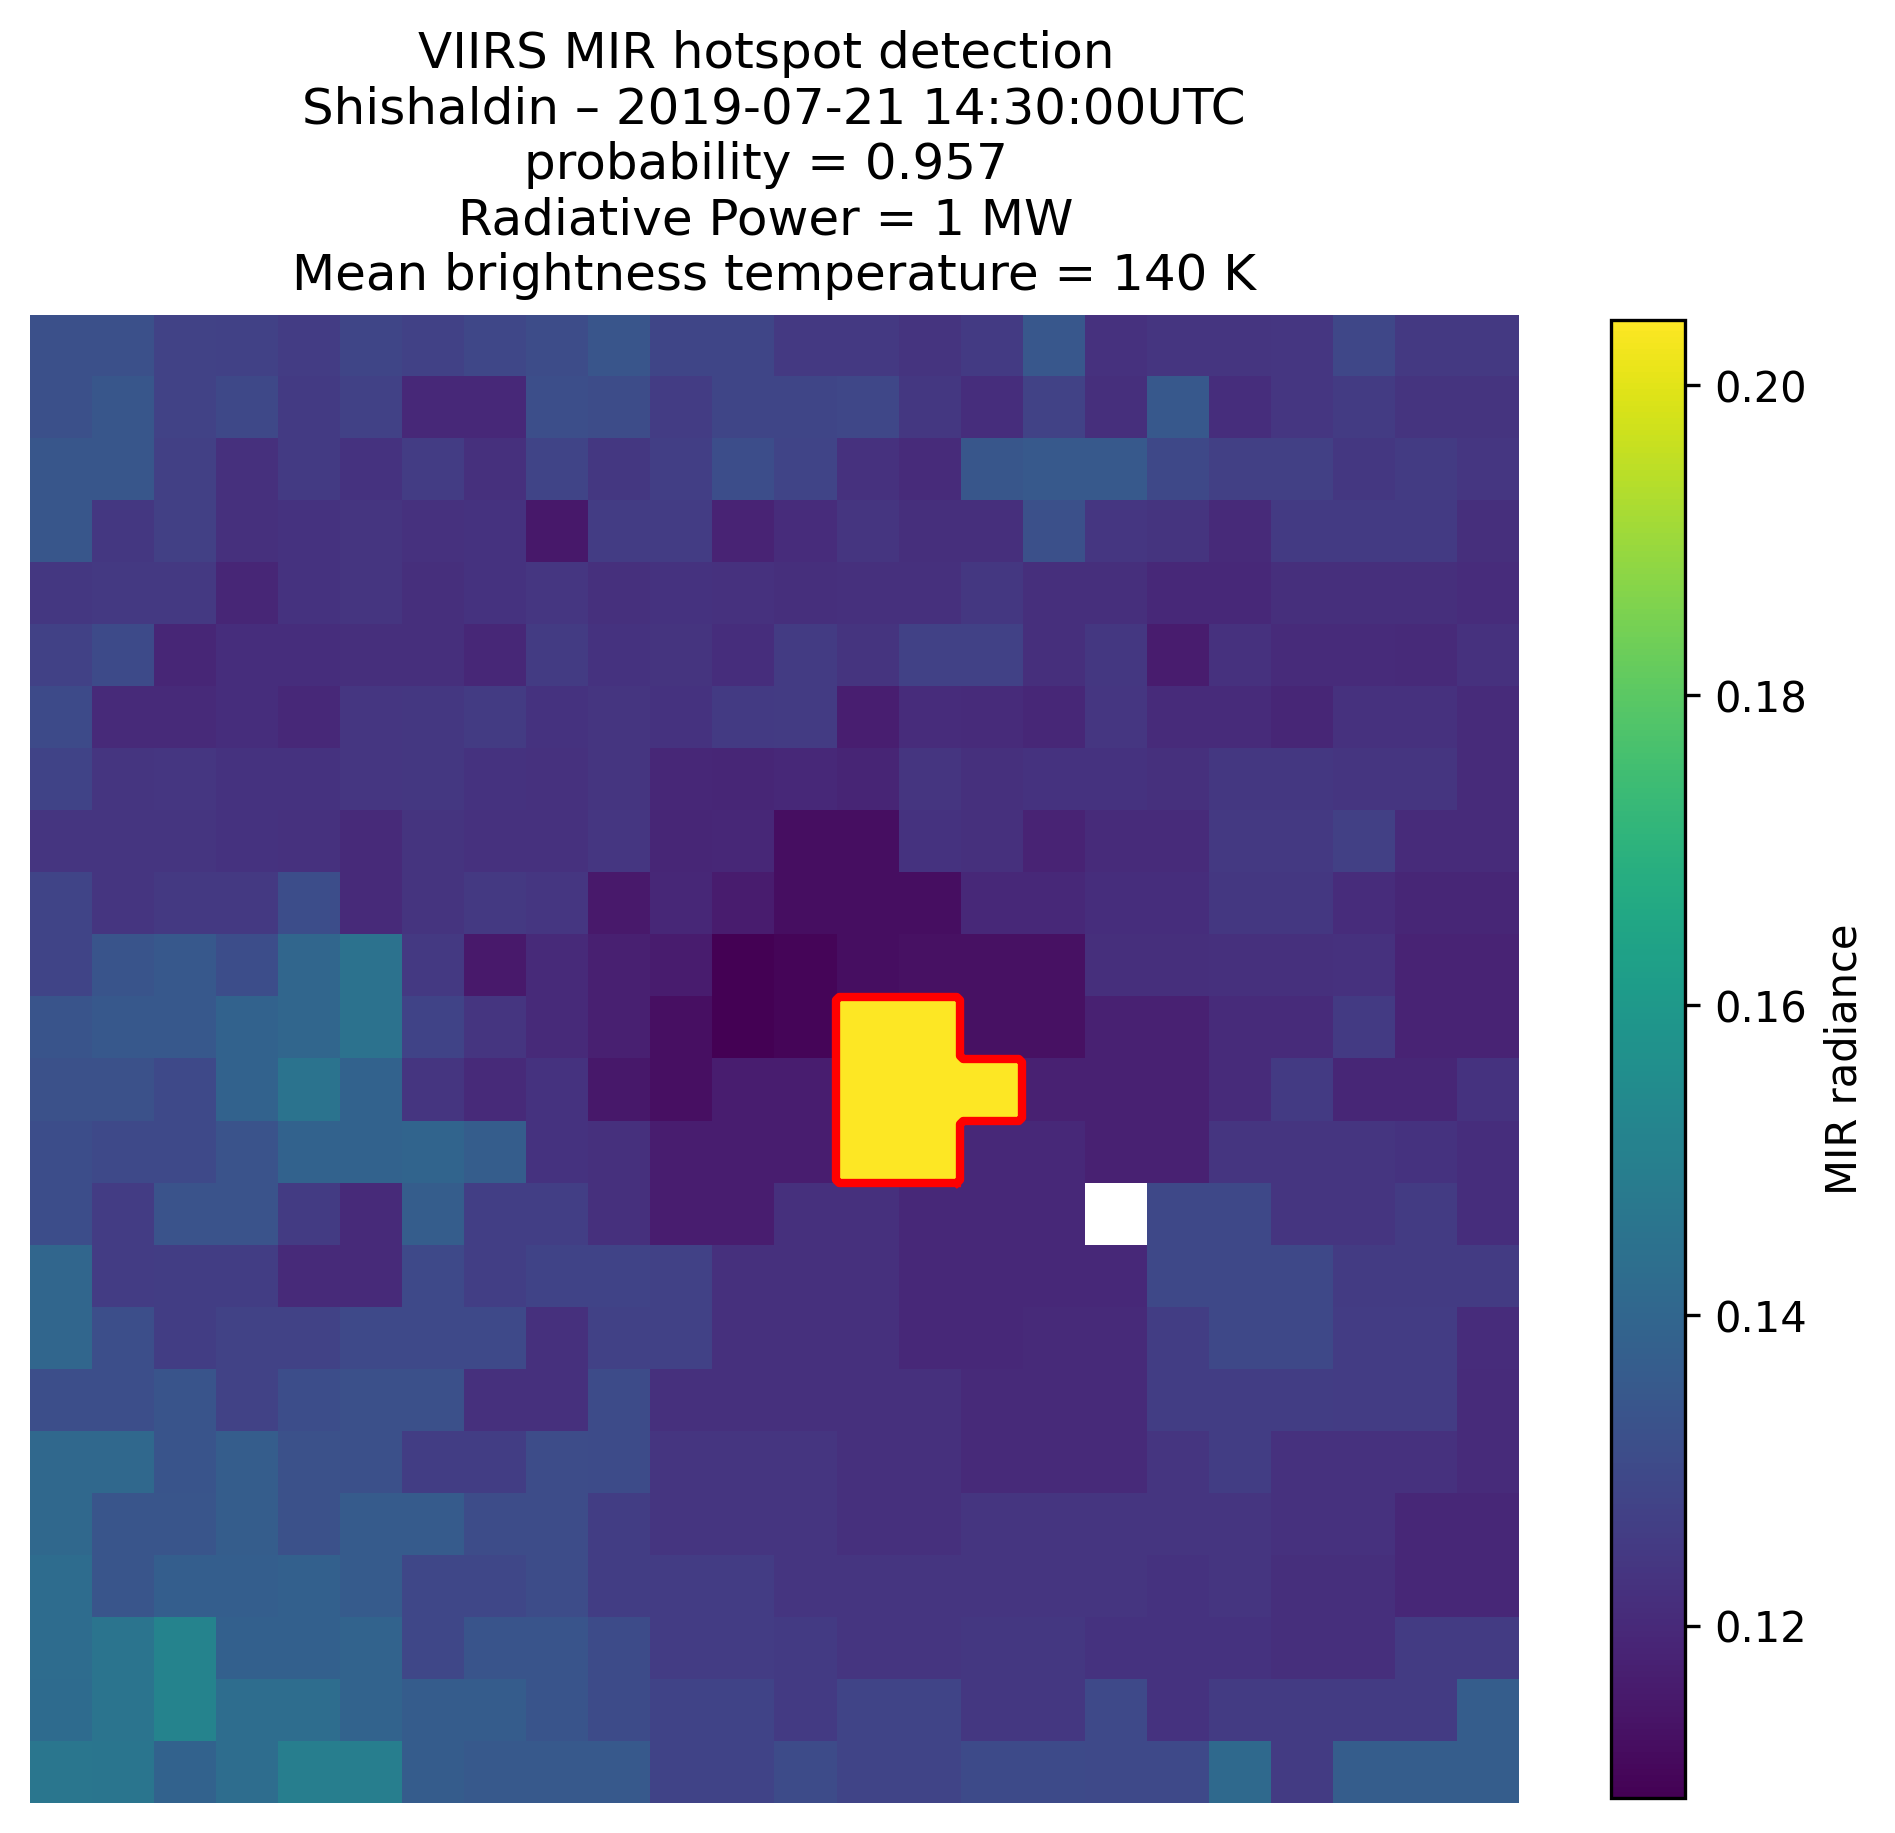

In [19]:
from hotlink.support_functions import radiative_power, brightness_temperature, plot_detection

# generate results:
mir_analysis = crop_center(mir, size=24) #crop to output size, for analysis
rp = radiative_power(mir_analysis, hotspot_mask, cellsize=371, rp_constant=17.34)

#get just hotspot pixels
hotspot = mir_analysis[ np.where(hotspot_mask==1) ]
hotspot_bt = np.mean(brightness_temperature(hotspot, wl=3.74e-6))
#we can also get brightness temperature of the background area in this way etc.

#Title the plot with lots of information
plt_title = f"VIIRS MIR hotspot detection \nShishaldin – {d8}UTC" + \
    f"\nprobability = {max_prob:.3f} \nRadiative Power = {rp/1e6:.0f} MW" + \
    f" \nMean brightness temperature = {hotspot_bt:.0f} K"

#Plot the detection using plot_detection function
plot_detection(mir_analysis, hotspot_mask, title=plt_title, outline_thickness=2)

# 6. Time series example
First load the entire example dataset, then normalize and crop the data using included functions. Then predict for the entire batch with shape [256,64,64,2]. Apply hysteresis thresholding, and radiative power calculation to the detections. Finally plot all detections as a time series.

 Original data shape is (256, 70, 70, 2)
Cropped shape is (256, 64, 64, 2)
8/8 [==============================] - 1s 137ms/step
predicted shape is (256, 24, 24, 3)


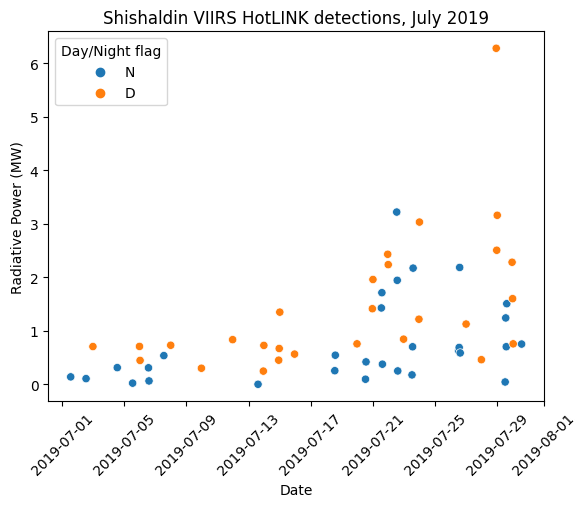

In [20]:
# load all example data
from hotlink import load_entire_example_dataset
from hotlink.support_functions import get_dn
import pandas as pd
import seaborn as sns

# load data and corresponding image dates
shis_data, image_dates = load_entire_example_dataset()
print(f" Original data shape is {shis_data.shape}")

# normalize MIR and TIR bands in place
dataset = np.copy(shis_data)
shis_data[:,:,:,0] = normalize_MIR(shis_data[:,:,:,0])
shis_data[:,:,:,1] = normalize_TIR(shis_data[:,:,:,1])

# crop to 64x64, note the use of 'crop_dimensions' to specify to crop the 1st and 2nd dimension to size 64
shis_data = crop_center(shis_data, size=64, crop_dimensions=(1,2))
print(f"Cropped shape is {shis_data.shape}")

# predict all images (does 8 batches of 32 images)
predictions = model.predict(shis_data)
print(f"predicted shape is {predictions.shape}")

# calculate metrics for all images:
active_probabilities = [ p[:,:,2] for p in predictions ]
masks = [ apply_hysteresis_threshold(ap, low=0.4, high=0.5).astype('int') for ap in active_probabilities ]
analysis_window = crop_center(dataset[:,:,:,0], size=24, crop_dimensions=(1,2)) #crop to output size, for analysis
rps_mw = [ radiative_power(mir, mask)/1e6 for mir,mask in zip(analysis_window, masks) ]

# format data into table, and get day/night flag for all images.
table = pd.DataFrame({"Radiative Power (MW)": rps_mw, "Date":image_dates})
table['Day/Night flag'] = [get_dn(dt, volcano_lat=54.7554, volcano_lng=163.9711, volcano_elevation=2857) for dt in image_dates]
detections = table.loc[table['Radiative Power (MW)']!=0]

# plot time series of detections
sns.scatterplot(data=detections, x='Date', y='Radiative Power (MW)', hue='Day/Night flag')
plt.xticks(rotation=45)
plt.title("Shishaldin VIIRS HotLINK detections, July 2019")
plt.show()

# Conclusions
In this small example of July 2019 data from Shishaldin, we see that Hotlink works well to detect hotspots, especially increases in thermal output which we see begin around July 20th. The day/night values also show that daytime detections typically have a higher radiative power than the nighttime detections.  